# Import

### Librerie

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import *

D:\Anaconda\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### Dataset

In [2]:
dataset = pd.read_csv('dataset.csv')
dataset.set_index(['date', 'sex', 'age', 'height', 'timezone'], inplace=True)

In [3]:
test_split=round(len(dataset)*0.20)
df_for_training=dataset[:-test_split]
df_for_testing=dataset[-test_split:]
print("shape del training set: {}".format(df_for_training.shape))
print("shape del test set: {}".format(df_for_testing.shape))
dataset.head()

shape del training set: (751741, 6)
shape del test set: (187935, 6)


,,,,,steps,bedin,bedout,sleep duration,deepduration,lightduration
date,sex,age,height,timezone,,,,,,
2016-04-19,Male,39.0,174.0,PDT,7716.87,24.08,6.81,5.98,1.08,4.87
2016-04-20,Male,39.0,174.0,PDT,7647.55,27.36,6.50,3.00,1.61,1.37
2016-04-21,Male,39.0,174.0,PDT,6041.68,23.79,7.93,7.61,3.40,4.22
2016-04-22,Male,39.0,174.0,PDT,5094.85,25.94,6.44,4.59,1.28,3.33
2016-04-23,Male,39.0,174.0,PDT,4428.15,25.50,11.75,9.91,4.98,4.84


In [4]:
# Normalizzazione
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled= scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.35766577, 0.51965812, 0.42921147, 0.35860656, 0.15584416,
        0.61647362],
       [0.35445247, 0.8       , 0.40143369, 0.05327869, 0.23232323,
        0.16602317],
       [0.28001307, 0.49487179, 0.52956989, 0.52561475, 0.49062049,
        0.53281853],
       ...,
       [0.24371281, 0.37179487, 0.35125448, 0.45696721, 0.67388167,
        0.28442728],
       [0.31973986, 0.39401709, 0.35035842, 0.43647541, 0.73881674,
        0.1981982 ],
       [0.38696   , 0.36324786, 0.35035842, 0.48258197, 0.61471861,
        0.36808237]])

In [5]:
#n_past is the number of step we will look in the past to predict the next target value.
col2pred = 4  # 0:steps, 1:bedin, 2:bedout, 3:sleep duration, 4:deep duration, 5:lightduration
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            #per ogni feature fa l'append dei precedenti
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            
            dataY.append(dataset[i,col2pred])
    return np.array(dataX),np.array(dataY)

window_size = 7
trainX,trainY=createXY(df_for_training_scaled,window_size)
testX,testY=createXY(df_for_testing_scaled,window_size)

In [6]:
# features num
features_num = dataset.shape[1]

# LSTM

In [7]:
#Creazione del modello
model = Sequential()
model.add(LSTM(256,return_sequences=True,input_shape=(window_size,features_num)))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 256)            269312    
                                                                 
 lstm_1 (LSTM)               (None, 7, 128)            197120    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 515,905
Trainable params: 515,905
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(trainX, trainY, epochs = 20, verbose = 1, batch_size = 4096) # 8192

Epoch 1/20
184/184 [==============================] - 13s 24ms/step - loss: 0.0249
Epoch 2/20
184/184 [==============================] - 4s 24ms/step - loss: 0.0187
Epoch 3/20
184/184 [==============================] - 4s 23ms/step - loss: 0.0180
Epoch 4/20
184/184 [==============================] - 4s 23ms/step - loss: 0.0175
Epoch 5/20
184/184 [==============================] - 4s 23ms/step - loss: 0.0170
Epoch 6/20
184/184 [==============================] - 4s 23ms/step - loss: 0.0166
Epoch 7/20
184/184 [==============================] - 4s 24ms/step - loss: 0.0163
Epoch 8/20
184/184 [==============================] - 4s 23ms/step - loss: 0.0160
Epoch 9/20
184/184 [==============================] - 4s 23ms/step - loss: 0.0158
Epoch 10/20
184/184 [==============================] - 4s 23ms/step - loss: 0.0156
Epoch 11/20
184/184 [==============================] - 4s 24ms/step - loss: 0.0155
Epoch 12/20
184/184 [==============================] - 4s 24ms/step - loss: 0.0154
Epoch 13/20


In [9]:
prediction_train = model.predict(trainX)
print("prediction\n", prediction_train)
print("\nPrediction Shape-", prediction_train.shape)

prediction_train_copies_array = np.repeat(prediction_train, 6, axis=-1)
pred_train = scaler.inverse_transform(np.reshape(prediction_train_copies_array, (len(prediction_train), 6)))[:, col2pred]
true_value_train_copies_array = np.repeat(trainY, 6, axis=-1)
true_value_train = scaler.inverse_transform(np.reshape(true_value_train_copies_array, (len(trainY), 6)))[:, col2pred]

prediction_test=model.predict(testX)
print("prediction\n", prediction_test)
print("\nPrediction Shape-",prediction_test.shape)

prediction_copies_test_array = np.repeat(prediction_test,6, axis=-1)
pred_test=scaler.inverse_transform(np.reshape(prediction_copies_test_array,(len(prediction_test),6)))[:,col2pred]
true_value_test_copies_array = np.repeat(testY,6, axis=-1)
true_value_test=scaler.inverse_transform(np.reshape(true_value_test_copies_array,(len(testY),6)))[:,col2pred]

23492/23492 [==============================] - 83s 3ms/step
prediction
 [[0.4115364 ]
 [0.44598272]
 [0.48293585]
 ...
 [0.6611341 ]
 [0.65686077]
 [0.651616  ]]

Prediction Shape- (751734, 1)
5873/5873 [==============================] - 21s 4ms/step
prediction
 [[0.61769587]
 [0.61712855]
 [0.63610864]
 ...
 [0.623152  ]
 [0.63000214]
 [0.62351984]]

Prediction Shape- (187928, 1)


**********TRAIN-SET***********
MAE: 0.657
MSE: 0.721
RMSE: 0.721
**********TEST-SET***********
MAE: 0.670
MSE: 0.747
RMSE: 0.747


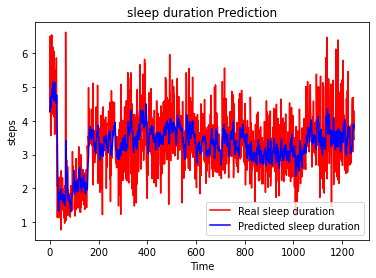

In [10]:
def metrics(true_value_train, pred_value_train, true_value_test, pred_value_test):
    print("**********TRAIN-SET***********")
    print("MAE: {:.3f}".format(mean_absolute_error(
        true_value_train, pred_value_train)))
    print("MSE: {:.3f}".format(
        mean_squared_error(true_value_train, pred_value_train)))
    print("RMSE: {:.3f}".format(
        mean_squared_error(true_value_train, pred_value_train, squared=True)))
    # metrics test set
    print("**********TEST-SET***********")
    print("MAE: {:.3f}".format(mean_absolute_error(
        true_value_test, pred_value_test)))
    print("MSE: {:.3f}".format(
        mean_squared_error(true_value_test, pred_value_test)))
    print("RMSE: {:.3f}".format(
        mean_squared_error(true_value_test, pred_value_test, squared=True)))
    

    plt.plot(true_value_test[:1250], color='red', label='Real sleep duration')
    plt.plot(pred_value_test[:1250], color='blue', label='Predicted sleep duration')
    plt.title('sleep duration Prediction')
    plt.xlabel('Time')
    plt.ylabel('steps')
    plt.legend()
    plt.show()


metrics(true_value_train, pred_train, true_value_test, pred_test)